In [1]:
import os, sys, re, cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from render2D import grid2D
from scipy.ndimage import maximum_filter

In [2]:
def saveCrop(img_path, xy, grid_size=64, ratio=10, offset=5):
    # offset between img and loc
    #img = cv2.imread(img_path)
    loc = img_path[:-3]+"txt"
    smlm = pd.read_table(loc, header=0)
    #xyz = smlm[["Xc","Yc","Zc"]]
    cropped = smlm.loc[ (xy[1]/(ratio+offset) <= smlm["Xc"]) 
                   & (smlm["Xc"] <= ((xy[1]+grid_size+offset))/ratio) 
                   & (xy[0]/(ratio+offset) <= smlm["Yc"]) 
                   & (smlm["Yc"] <= (xy[0]+grid_size+offset)/ratio)]
    cropped.loc[:,"Xc"] = cropped["Xc"]*ratio-xy[1]-offset
    cropped.loc[:,"Yc"] = cropped["Yc"]*ratio-xy[0]-offset
    sub_path = "/".join(img_path.split("/")[:-1])+"/sub_"+img_path.split("/")[-1][:-4]+"_x"+str(xy[1])+"_y"+str(xy[0])+"_grid"+str(grid_size)
    cropped.to_csv(sub_path+".txt", index=False)
    xc=np.array(cropped["Xc"].tolist()).astype(np.int32)
    yc=np.array(cropped["Yc"].tolist()).astype(np.int32)
    img=grid2D(np.zeros([grid_size,grid_size], dtype=np.int32),xc,yc,grid_size,grid_size,len(xc))
    g = cv2.getGaussianKernel(3, sigma=1)
    kernel = g*g.T
    nimg = scipy.signal.fftconvolve(img, kernel, mode='same')
    plt.imshow(nimg.T)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.savefig(sub_path+".png", facecolor=None, edgecolor=None, bbox_inches='tight',pad_inches=0.0)
    return sub_path, nimg.T

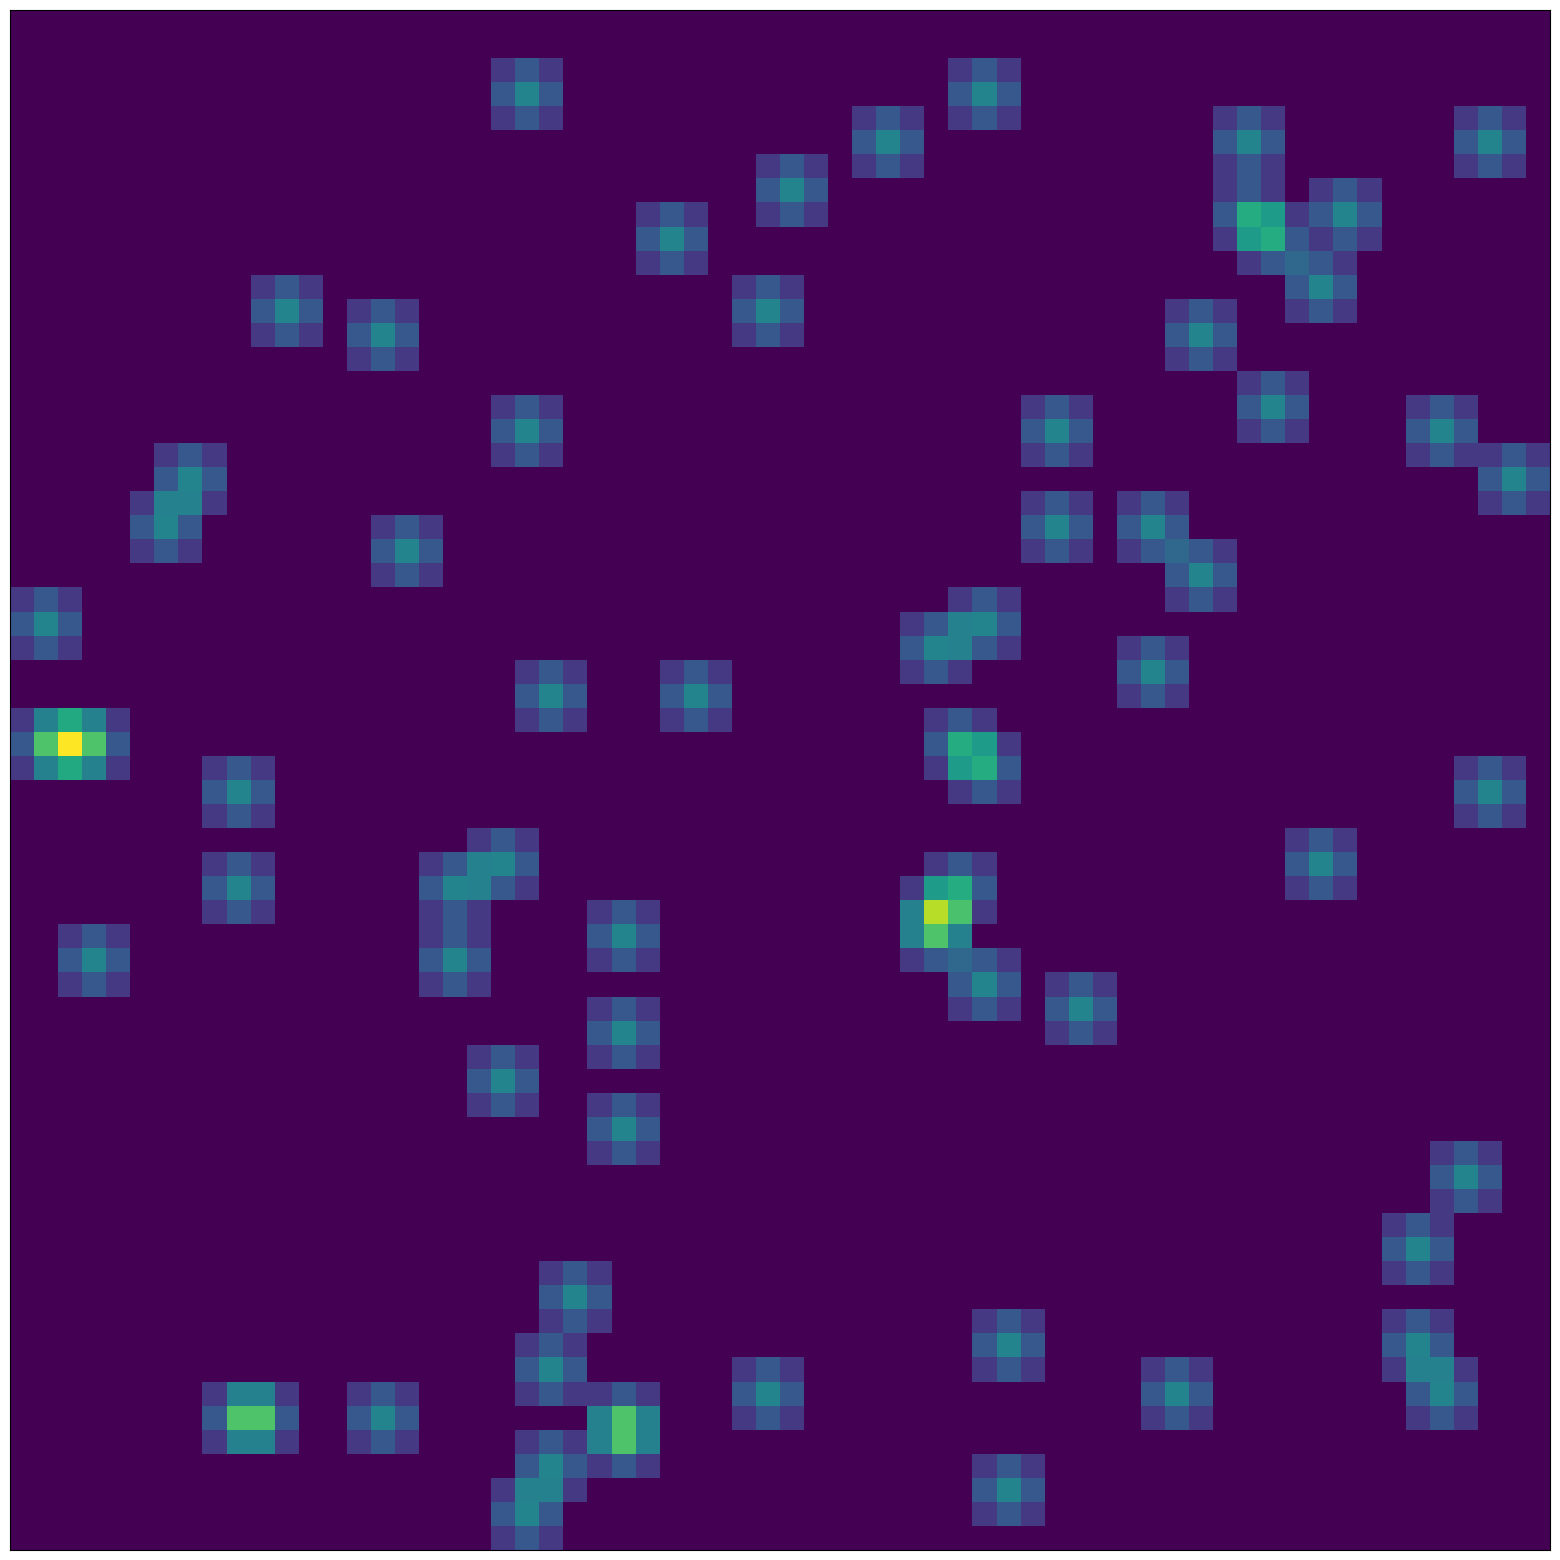

In [16]:
from matplotlib.patches import Rectangle
img_path="../data/rendered/soma/0227_11.png"
img = cv2.imread(img_path)
plt.figure(figsize=[20,20])
x0=1050
y0=900
plt.imshow(img[x0:1800,y0:1700])

for i in range(30,700,64):
    for j in range(50,660,64):
        x = i
        y = j
        xy = [x0+x, y0+y]
        #plt.gca().add_patch(Rectangle((y,x),64,64,linewidth=3,edgecolor="red",facecolor='none'))
        #plt.figure()
        grid_size = 64
        a,b=saveCrop(img_path, xy)
        #plt.imshow(img[xy[0]:xy[0]+grid_size,xy[1]:xy[1]+grid_size])

In [ ]:
smlm = pd.read_csv(sub_path+'.txt', header=0)
xc=np.array(smlm["Xc"].tolist()).astype(np.int32)
yc=np.array(smlm["Yc"].tolist()).astype(np.int32)
img = grid2D(np.zeros([grid_size,grid_size], dtype=np.int32),xc,yc,grid_size,grid_size,len(xc))
g = cv2.getGaussianKernel(3, sigma=1)
kernel = g*g.T
nimg = scipy.signal.fftconvolve(img, kernel, mode='same')
plt.imshow(nimg)

In [ ]:
from matplotlib.patches import Rectangle
img_path="../data/rendered/soma/0227_9.png"
img = cv2.imread(img_path)
plt.figure(figsize=[20,20])
plt.imshow(img[800+64*3:1600,800+64*3:1600])
for i in range(50,400,64):
    for j in range(60,500,64):
        x = i
        y = j
        xy = [800+x+64*3, 800+64*3+y]
        plt.gca().add_patch(Rectangle((y,x),64,64,linewidth=3,edgecolor="red",facecolor='none'))
        #plt.figure()
        grid_size = 64
        #a,b=saveCrop(img_path, xy)
        #plt.imshow(img[xy[0]:xy[0]+grid_size,xy[1]:xy[1]+grid_size])

In [ ]:
x,y = 1170,1308
plt.imshow(img[x:x+64,y:y+64])

In [ ]:
from matplotlib.patches import Rectangle
img_path="../data/rendered/soma/1226_5.png"
img = cv2.imread(img_path)
plt.figure(figsize=[20,20])
plt.imshow(img[800:1400,1100:1700])
for i in range(30,500,64):
    for j in range(0,560,64):
        x = i
        y = j
        xy = [800+x, 1100+y]
        #plt.gca().add_patch(Rectangle((y,x),64,64,linewidth=3,edgecolor="red",facecolor='none'))
        #plt.figure()
        grid_size = 64
        a,b=saveCrop(img_path, xy)
        #plt.imshow(img[xy[0]:xy[0]+grid_size,xy[1]:xy[1]+grid_size])

In [ ]:
from matplotlib.patches import Rectangle
img_path="../data/rendered/soma/1226_5.png"
img = cv2.imread(img_path)
plt.figure(figsize=[20,20])
plt.imshow(img[800:1400,1100:1700])
for i in range(30,500,64):
    for j in range(0,560,64):
        x = i
        y = j
        xy = [800+x, 1100+y]
        plt.gca().add_patch(Rectangle((y,x),64,64,linewidth=3,edgecolor="red",facecolor='none'))
        #plt.figure()
        grid_size = 64
        #a,b=saveCrop(img_path, xy)
        #plt.imshow(img[xy[0]:xy[0]+grid_size,xy[1]:xy[1]+grid_size])

In [ ]:
def autocontrast(img, thre=5):
    '''
    img is a one-channel image
    thre in 0-100
    '''
    up = np.percentile(img,100-thre)
    low = np.percentile(img,thre)
    #print(up, low)
    img = 255*(img-low)/(up-low)
    img[img>255]=255
    img[img<0]=0
    return img.astype(np.uint8)

def lmax_loc(loc_file, regions, rimg, adapt=55, local=7, plot=0, verbose=0,sm=4):
    if loc_file is not None:
        smlm=pd.read_table(loc_file,header=0)
        test=smlm[["Xc","Yc","Zc"]]
        img = np.zeros([regions[1]-regions[0], regions[3]-regions[2]],dtype=np.int32)

        xc=test["Xc"].tolist()
        yc=test["Yc"].tolist()
        xc=np.array([ int(x*10-regions[0]) for x in xc]).astype(np.int32)-5
        yc=np.array([ int(x*10-regions[2]) for x in yc]).astype(np.int32)-5
        img=grid2D(img,xc,yc,regions[1]-regions[0], regions[3]-regions[2],len(xc))
        img=np.array(img)
    else:
        if len(rimg.shape)==3:
            img=cv2.cvtColor(rimg, cv2.COLOR_BGR2GRAY)
        img=rimg.T
    blur=autocontrast(img.T)
    blur=cv2.blur(blur,(sm,sm))
    #blur=fftconvolve(img.T,cv2.getStructuringElement(cv2.MORPH_ELLIPSE , (3,3)), mode='same')
    #blur=(255*blur/np.max(blur)).astype(np.uint8)
    th=cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, adapt, 0)
    #th1=cv2.threshold(blur.astype(np.uint8), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    # filter out the small ones
    kernel=np.ones([sm,sm])
    th1=cv2.erode(th,kernel)
    th2=cv2.dilate(th1,kernel)
    lmax = blur*(blur == maximum_filter(blur, footprint=np.ones((local,local))))
    #plt.figure(figsize=[20,20])
    #plt.imshow(th)
    #cell_mask = getCellMask(blur)
    contours,_ = cv2.findContours(lmax.astype(np.uint8)&th2,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour_centers = np.zeros([len(contours),2])
    for i in range(len(contours)):
        contour_centers[i] = contours[i].reshape([-1,2]).mean(axis=0)

    if plot==1:
        #plt.figure(figsize=[20,20])
        plt.imshow(rimg)
        plt.plot(
            contour_centers[:, 0],
            contour_centers[:, 1],
            ".",
            markerfacecolor="red",
            markersize=10,
        )
        
    if verbose==1:
        plt.figure()
        plt.subplots(2,3)
        i=0
        for timg in [img.T, blur, th, th1, th2, lmax]:
            i+=1
            plt.subplot(2,3,i)
            plt.imshow(timg)
    return blur,contour_centers


In [ ]:
for i in range(2,7):
    print(i)
    g = cv2.getGaussianKernel(3, sigma=i/4)
    kernel = g*g.T

    img = scipy.signal.fftconvolve(img, kernel, mode='same')
    plt.figure()
    #plt.imshow(img)
    vxs = lmax_loc(None,None,nimg,adapt=55,local=7,sm=3,plot=1)[1]

In [ ]:
sub_path = "sub_"+img_path.split("/")[-1][:-3]+"_x"+str(xy[1])+"_y"+str(xy[0])+"_grid"+str(grid_size)
cropped.to_csv(sub_path, index=False)
